In [1]:
import typing as tp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn

sns.set(font_scale=1.4, palette='Set2')

In [2]:
# Bot check

# HW_ID: ds_ml8
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

## Исследование простой модели (60 баллов)

Это последний ноутбук в данном домашнем задании. Здесь вы исследуете влияние величины линейного слоя, инициализации и разных функций активации на обучение простой двухслойной модели. В качестве данных будет использоваться синтетическая выборка соответствующая примеру на лекции.

В данном ноутбуке **можно и нужно пользоваться PyTorch**. Все эксперименты будут вычислительно простыми, поэтому CUDA здесь не понадобится.

### 1. Реализация

Рассмотрим функцию с лекции:
$$f(x) = 0.2 + 1.4 x^2 + 0.3\sin(15x) + 0.1\cos(50x)$$
Будем приближать эту функции на отрезке $[0, 1]$ двухслойной нейронной сетью.
* Первый слой будет содержать обучаемые веса и смещения. А также некоторую функцию активации $\sigma(x)$.
* Второй слой будет содержать только обучаемые веса (без смещения), а функция активации будет тождественной.

Если в качестве $\sigma(x)$ взять функцию индикатора, то поулчится нейронная сеть точь в точь такая же как на лекции.

Начнем с простого. Реализуйте заданную функцию.

In [3]:
def function(x: torch.Tensor):
    return 0.2 + 1.4 * x** 2 + 0.3 * torch.sin(15 * x) + 0.1 * torch.cos(50 * x)

In [4]:
assert torch.allclose(function(torch.tensor(0)), torch.tensor(0.3), 1e-4)
assert torch.allclose(function(torch.tensor(1)), torch.tensor(1.8916), 1e-4)
assert torch.allclose(function(torch.tensor(0.5)), torch.tensor(0.9305), 1e-4)

Реализуйте модель двухслойной нейронной сети как в описании.

In [5]:
class MyModel(nn.Module):
    """
    Двухслойная нейронная сеть.
    * n_hidden - количество нейронов на первом слое;
    * activation - функция активации на первом слое.
    """
    
    def __init__(
        self, 
        n_hidden: int,
        activation: tp.Callable[[torch.Tensor], torch.Tensor]
    ):
        super(MyModel, self).__init__()
        # Первый линейный слой: от 1 входа к n_hidden нейронам
        self.l1 = nn.Linear(in_features=1, out_features=n_hidden)
        # Функция активации
        self.activation = activation
        # Второй линейный слой: от n_hidden нейронов к 1 выходу без смещения
        self.l2 = nn.Linear(in_features=n_hidden, out_features=1, bias=False)
    
    def forward(self, x):
        # Пропускаем через первый слой
        out = self.l1(x)
        # Применяем функцию активации
        out = self.activation(out)
        # Пропускаем через второй слой (тождественная функция активации)
        out = self.l2(out)
        return out

Сгенерируйте значения $x$ с помощью равномерной сетки с шагом 0.01 на отрезке $[0, 1]$. Также посчитайте соответствующие значения $f(x)$.

In [6]:
x = torch.linspace(0, 1.01, 101).unsqueeze(1)
y_true = function(x)
assert x.shape == y_true.shape == (101, 1)

Напишите функцию для обучения сети. В данном случае, мы будем подавать в сеть всю выборку сразу, поэтому нет необходимости по ней итерироваться. По ходу обучения будет сохраняться поле `loss`. Это скаляр, поэтому при сохранении используем метод тензора `item`.

In [7]:
def train(model, optimizer, criterion, x, y, n_epochs):
    """
    Цикл обучения нейронной сети.
    * model - модель;
    * optimizer - оптимизатор;
    * critetion - функция ошибки;
    * x - входные данные;
    * y - выходные данные;
    * n_epochs - количество эпох обучения;
    """

    # история обучения
    history = {'loss': []}

    # вводим в привычку
    model.train()

    # цикл обучения
    for i in range(n_epochs):

        loss = criterion(model.forward(x), y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        history['loss'].append(loss.item())

    return history

Напишите функцию для получения предсказания. Воспользуйтесь конструкцией, которая позволяет не считать градиенты при прогоне модели.

In [8]:
def eval(model, x):
    """
    Предскзание модели.
    * model - модель;
    * x - входные данные.
    """

    # вводим в привычку
    model.eval()
    with torch.no_grad():
        y_pred = model(x)

    return y_pred

В качестве лосса и метрики будем использовать MSE.

In [11]:
mse = torch.nn.MSELoss()

### 2. Эксперименты

Для начала в качестве функции активации $\sigma(x)$ возьмем индикатор $I\{x > 0\}$ как на лекции.

In [12]:
def indicator(x, threshold=0):
    return (x > threshold).to(torch.float32)

Инициализируйте модель. Сохраним значения весов модели. Сделайте одну итерацию обучения (одну эпоху). В качестве оптимизатора используем `SGD`. Сравните новые веса модели со старыми. Объясните результат.

In [13]:
model = MyModel(n_hidden=2, activation=indicator)

# веса до итерации обучения
w1_init = model.l1.weight.detach().clone()
b1_init = model.l1.bias.detach().clone()
w2_init = model.l2.weight.detach().clone()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
train(model, optimizer, mse, x, y_true, 1)

# веса после итерации обучения
w1_new = model.l1.weight.detach().clone()
b1_new = model.l1.bias.detach().clone()
w2_new = model.l2.weight.detach().clone()

torch.allclose(w1_init, w1_new), torch.allclose(b1_init, b1_new), torch.allclose(w2_init, w2_new)

(True, True, False)

**Ответ:** Видимо, проведение лишь одной эпохи сильно сказывается на весах "внешнего" второго слоя, но почти не влияет на внутренний.

Попробуем сгладить наш индикатор. Реализуйте другую функцию активации &mdash; *сигмоиду с температурой*.
Ее отличие от обычной состоит в множителе в показателе экспоненты:

$$f(x) = \frac{1}{1 + e^{-T \cdot x}}$$

In [14]:
def tempered_sigmoid(x, temperature=50):
    """
    Сигмоида с температурой
    * input - входной тензор;
    * T - температура
    """
    return 1 / (1 + torch.exp(-temperature * x))

Визуализируйте зависимость от температуры:

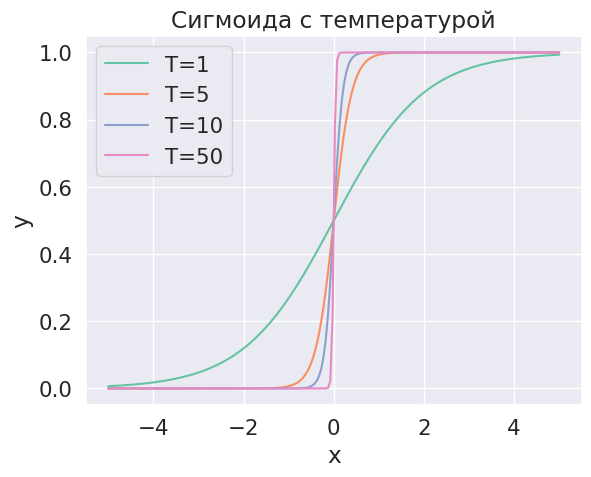

In [15]:
grid = torch.linspace(-5, 5, 200)
temperatures = [1, 5, 10, 50]
for temp in temperatures:
    y = tempered_sigmoid(grid, temp)
    plt.plot(grid, y, label=f'T={temp}')
    plt.xlabel('x')
    plt.ylabel('y')
plt.title('Сигмоида с температурой')
plt.legend()
plt.show()

Сравним эти функции активации с еще тремя, которые были у вас на лекции: `ReLU`, `LeakyReLU`, `GELU`. У каждой зададим `learning_rate`.

In [16]:
activation_functions = {
    'Индикатор': [indicator, 0.01],
    'Сигмоида (t)': [tempered_sigmoid, 0.01],
    'ReLU     ': [nn.ReLU(), 0.1],
    'LeakyReLU': [nn.LeakyReLU(), 0.1],
    'GELU     ': [nn.GELU(), 0.1]
}

Инициализируйте и обучите модель с каждой функцией активации 5 раз, и выберете лучшее предсказание по MSE. Построим график с лучшим предсказанием для каждой функции активации. Сравните эти предсказания между собой по MSE. Отличаются ли предсказания в случаях индикаторной функции и сигмоиды?

Индикатор 	 0.0141
Сигмоида (t) 	 0.0088
ReLU      	 0.0402
LeakyReLU 	 0.0238
GELU      	 0.0418


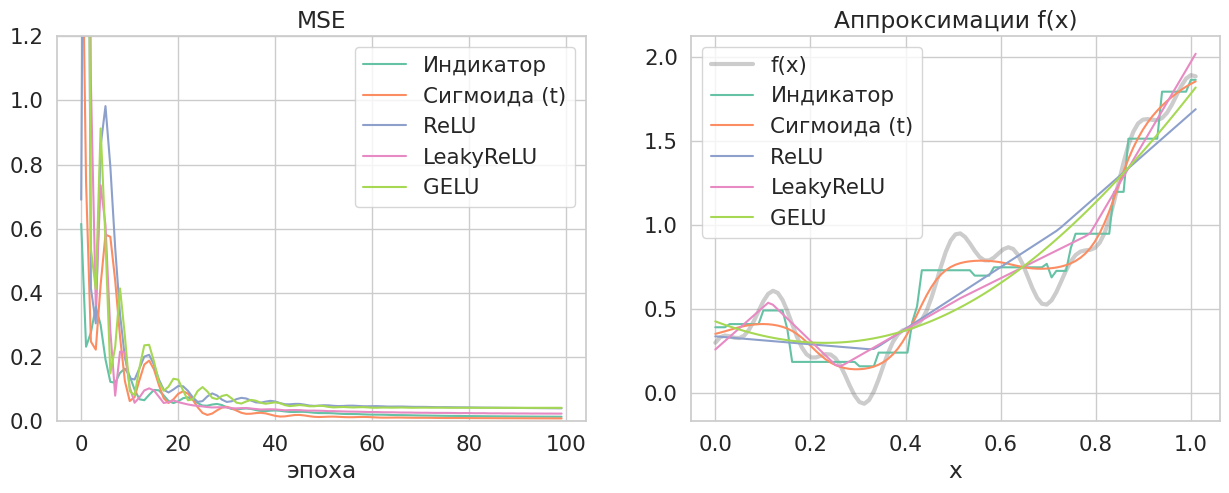

In [72]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[1].plot(x.ravel(), y_true.ravel(), label='f(x)',
            color='grey', lw=3, alpha=.4)
n_times = 5
n_epochs = 100
for name, (func, lr) in activation_functions.items():
    MSEs = []
    y_preds = []
    for i in range(n_times):
        model = MyModel(n_hidden=100, activation=func)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        history = train(model, optimizer, mse, x, y_true, n_epochs)
        y_preds.append(eval(model, x).ravel().detach())
        MSEs.append(history['loss'])
    MSEs = np.array(MSEs)
    best = np.nanargmin(MSEs[:, -1])
    print(name, '\t', np.round(MSEs[best][-1], 4))

    axs[0].plot(MSEs[best], label=name)
    axs[1].plot(x.ravel(), y_preds[best].ravel(), label=name)

axs[0].legend()
axs[1].legend()
axs[0].set_title('MSE')
axs[1].set_title('Аппроксимации f(x)')
axs[0].set_xlabel('эпоха')
axs[1].set_xlabel('x')
axs[0].set_ylim(0, 1.2)

plt.show()

**Ответ:** Предсказания с сигмоидой и с индикатором отличаются, при том существенно. С индикатором мы предсказываем "ступеньками", в то время как сигмодида приближает гладкой функцией. Темне менее, это две лучших функции активации, т.к. они лучше всего отражают все особенности приближаемой функции.

Вернемся к индикаторной функции активации. Исследуйте то, как обучается модель в зависимости от ширины первого слоя (ширина = кол-во нейронов). Рассмотрим значения 5, 10, 20, 50, 100.  Теперь будем запускать инициализацию по 100 раз. Не беспокойтесь, считается довольно шустро. Для каждой ширины слоя, построим графики зависимости функции ошибки от эпохи обучения. Также построим график среднего предсказания с доверительным интервалом ширины $2\sigma$ (здесь корень из дисперсии), сравните его с $f(x)$. Сделайте выводы.

In [ ]:
n_times = 

In [32]:
def test_different_hidden_sizes(activation_function):
    sns.set_style("whitegrid")
    for n_hidden in (5, 10, 20, 50, 100, 10000):
        fig, axs = plt.subplots(1, 2, figsize=(12, 4))
        y_preds = []
        MSEs = []

        for i in range(n_times):
            model = MyModel(n_hidden, activation_function)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
            loss_history = train(model, optimizer, mse, x, y_true, 200)['loss']
            y_pred = eval(model, x)
            MSEs.append(mse(y_pred, y_true))
            y_preds.append(y_pred.ravel().detach())
            axs[0].plot(loss_history, color='blue', alpha=0.1)

        # предсказания, их средние и стандартное отклонение
        y_preds = torch.stack(y_preds)
        y_pred_mean = torch.mean(y_preds, dim=0)
        y_pred_std = torch.var(y_preds, dim=0)

        axs[1].plot(x, y_pred_mean, color='blue', label='среднее предсказ.')
        axs[1].fill_between(
            x.ravel(), y_pred_mean - y_pred_std * 2, y_pred_mean + y_pred_std * 2,
            alpha=0.1, color='blue', label='дов. интервал')
        axs[1].plot(x.ravel(), y_true.ravel(), label='f(x)', color='#00BB99', lw=3)

        mse_mean = torch.mean(torch.tensor(MSEs))

        axs[1].legend()
        axs[0].set_title(f'MSE ~ {mse_mean:.2f}')
        axs[1].set_title('Аппроксимации f(x)')
        axs[0].set_xlabel('эпоха')
        axs[1].set_xlabel('x')
        axs[0].set_ylim(0, 1.2)
        plt.tight_layout()

        fig.suptitle(f'{n_hidden} нейронов в 1-м слое')
        plt.show()

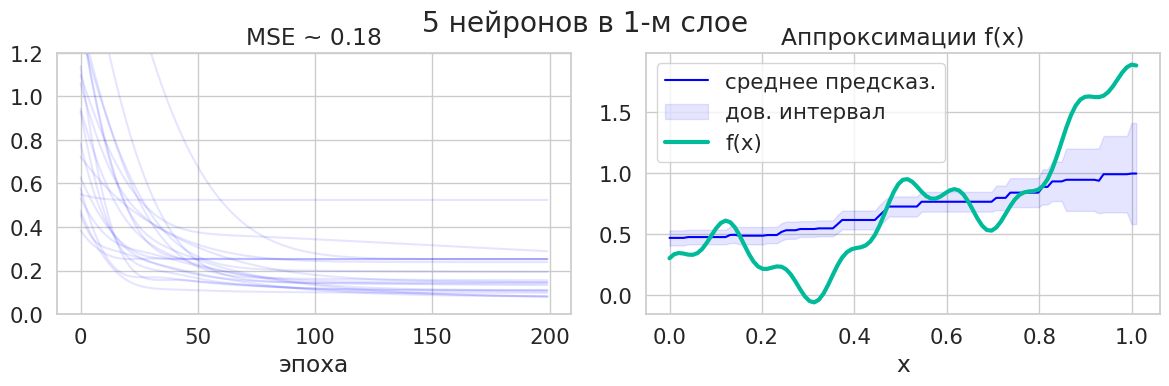

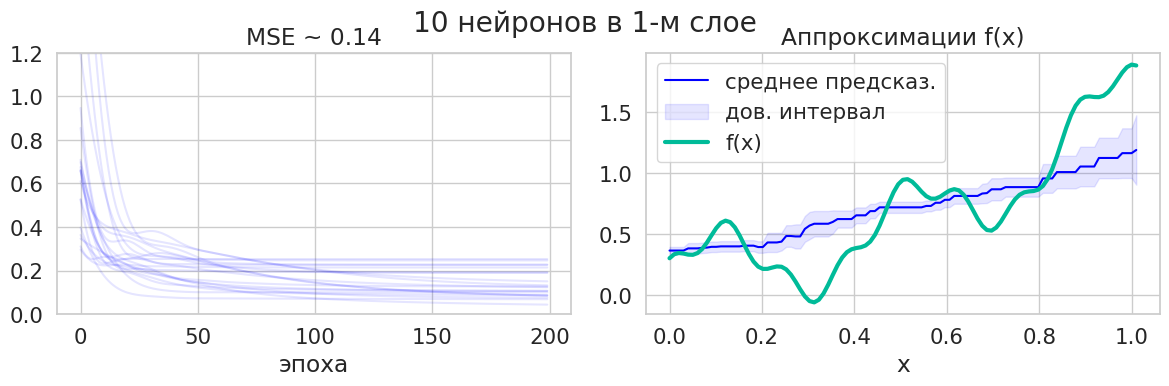

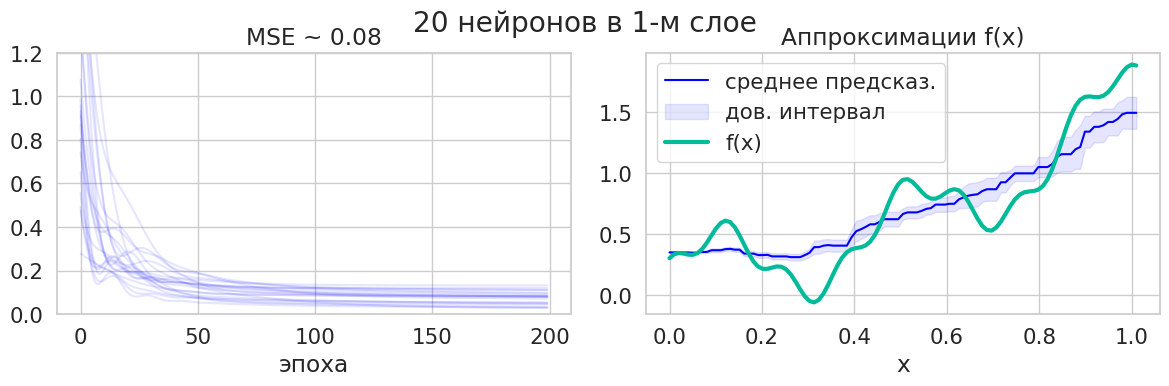

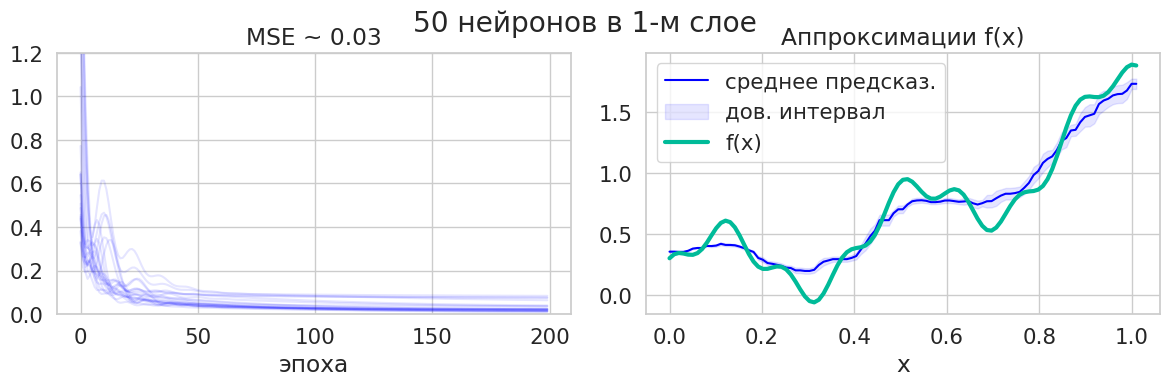

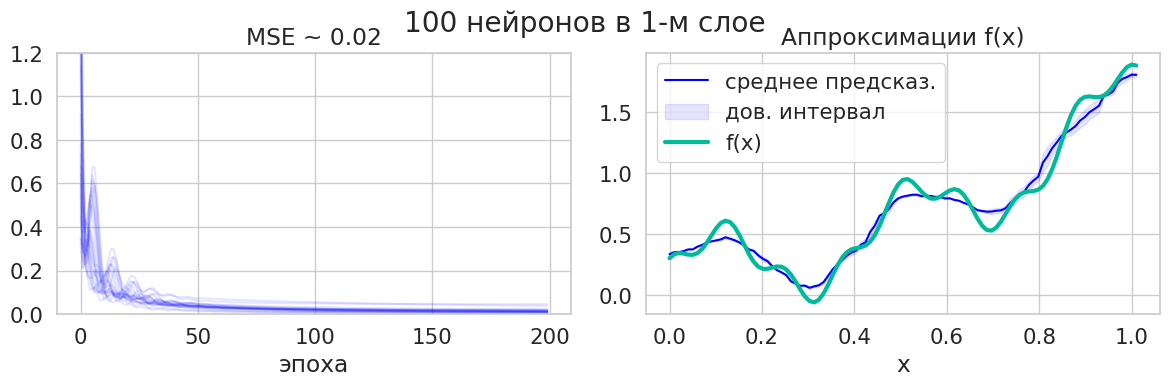

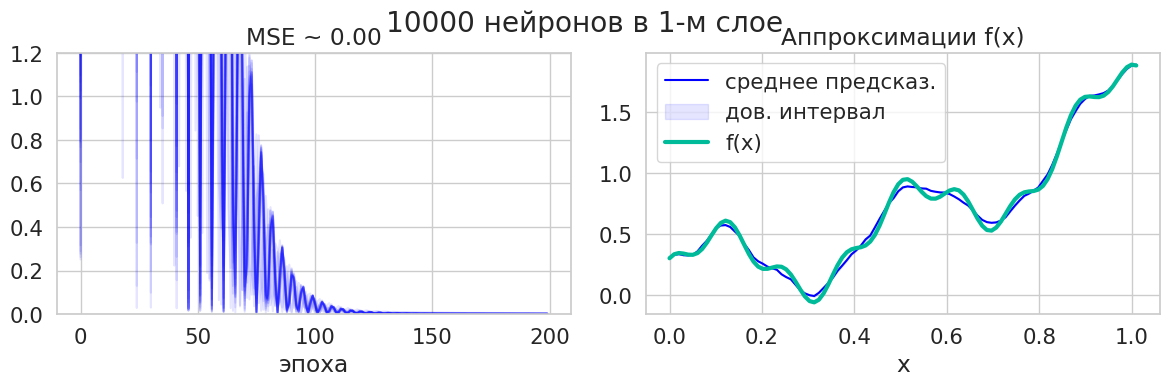

In [33]:
test_different_hidden_sizes(indicator)

Повторите то же самое для функции активации ReLU. Сделайте выводы.

/tmp/ipykernel_18675/656057411.py:20: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1808.)
  y_pred_std = torch.var(y_preds, dim=0)


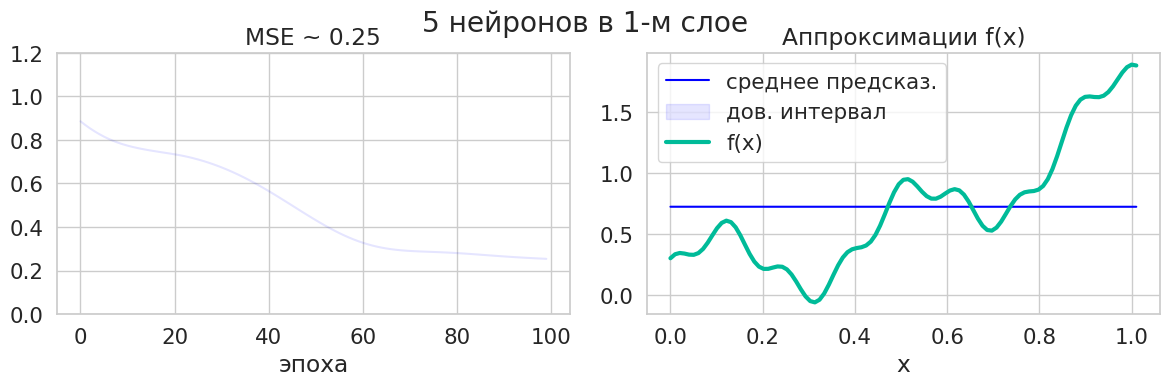

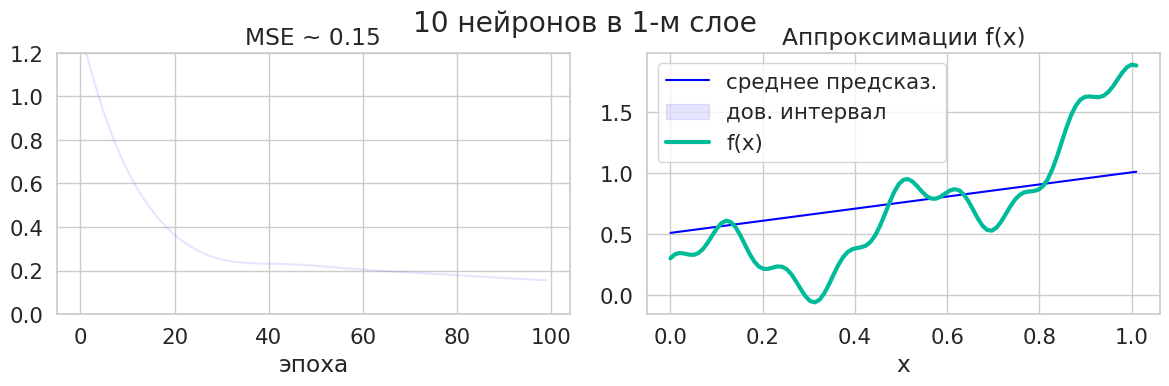

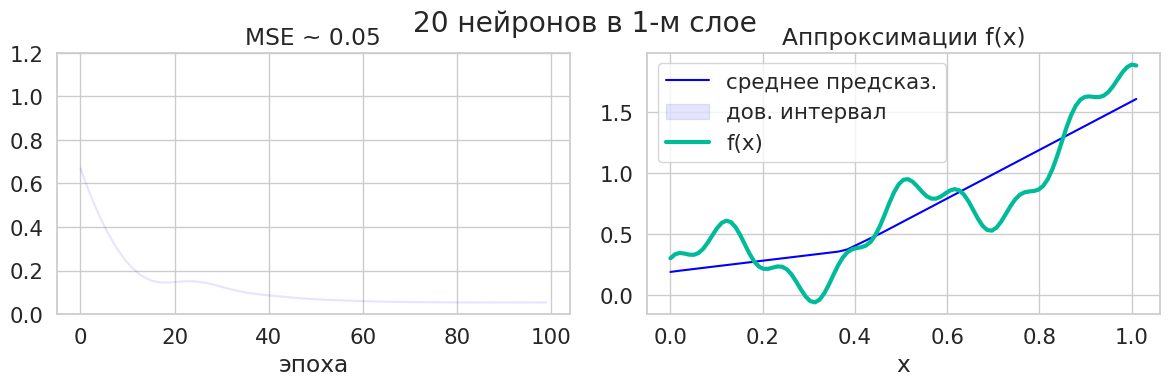

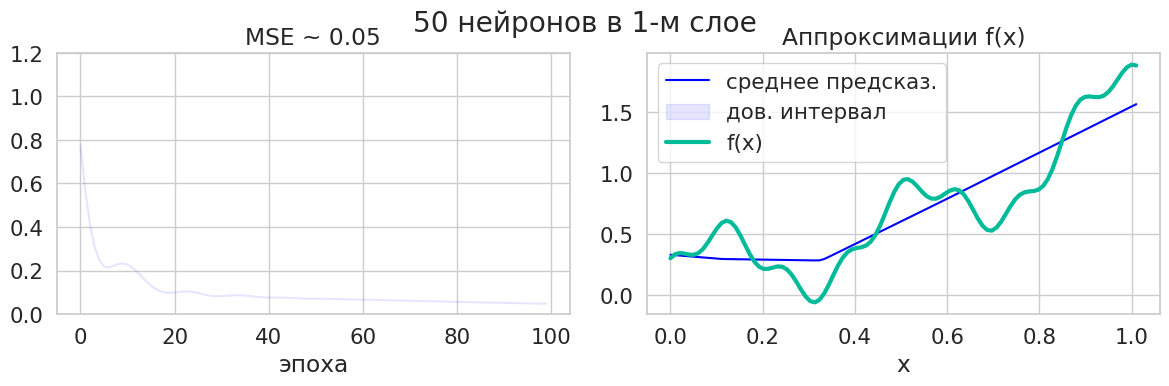

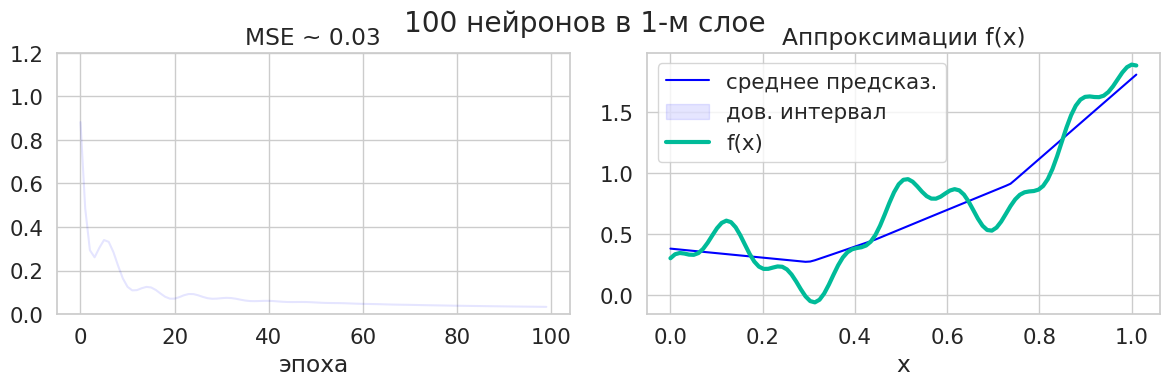

In [20]:
test_different_hidden_sizes(nn.ReLU())

**Ответ:** Видно, что с индикатором увеличение количества нейронов позволяет существенно точнее и с меньшей дисперсией приближать функцию. В то же время с ReLU дисперсия падает, но форма предсказаний меняется незначительно, в итоге мы пытаемся приближать очень нелинейную функцию почти линейными кусками.

---
**Вывод**
1. Написали свой класс для приближения сложных нелинейных функий
2. Функция активации вносит существенный вклад в точность предсказаний
3. В случае приближения сложных нелинейных функций валидны только сигмоида и индикатор, остальные либо не вносят нелинейность, либо плохо приближают конкретную форму функции